In [1]:
from mnist import MNIST
import os
import numpy as np
from tensorflow.keras.utils import to_categorical

mndata = MNIST('mnist')

X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [2]:
np.shape(X_test)

(10000, 784)

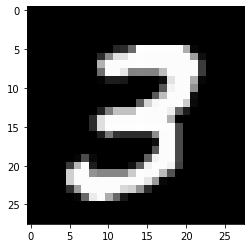

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [108]:
import matplotlib.pyplot as plt
import numpy as np

id = 7

image = np.array(X_train[id], dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

#print(X_train[id])
print(y_train[id])

In [48]:
#Tuning the hyperparameters for optimizers
from keras.layers import Dense 
from keras.models import Sequential 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

optimizers=['sgd','rmsprop','adam','adagrad']
for i in optimizers:
    def create_model():
        model = Sequential()
        model.add(Dense(32, activation='sigmoid', input_shape=(784,)))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=i,  
                      metrics=['accuracy'])
        return model

    model = KerasClassifier(build_fn=create_model,verbose=0)
    batchsize = [64,128,256,512,1024]
    epochs = [5,10]
    param_grid=dict(batch_size=batchsize,epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train,verbose=0)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_),i)

Best: 0.898400 using {'batch_size': 64, 'epochs': 10} sgd
Best: 0.910733 using {'batch_size': 128, 'epochs': 10} rmsprop
Best: 0.903933 using {'batch_size': 256, 'epochs': 10} adam
Best: 0.764733 using {'batch_size': 64, 'epochs': 10} adagrad


In [99]:
# Neural network
model = Sequential()
model.add(Dense(32, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                25120     
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compiling model for sgd optimizer
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',   
              metrics=['accuracy'])        

hist = model.fit(X_train,y_train,
                    batch_size=64,
                    epochs=10, 
                    verbose=0)
print("Average accuracy:",np.mean(hist.history['accuracy']))
result = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", result[0])
print("Test accuracy: ", result[1])

Average accuracy: 0.8687099993228913
Test score:  0.34560734033584595
Test accuracy:  0.9031999707221985


In [52]:
# Compiling model for rmsprop optimizer
model.compile(optimizer="rmsprop", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

hist = model.fit(X_train,y_train,
                    batch_size=128,
                    epochs=10, 
                    verbose=0)
print("Average accuracy:",np.mean(hist.history['accuracy']))
result = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", result[0])
print("Test accuracy: ", result[1])

Average accuracy: 0.9205466568470001
Test score:  0.24513554573059082
Test accuracy:  0.927299976348877


In [53]:
# Compiling model for adam optimizer
model.compile(optimizer="adam", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

hist = model.fit(X_train,y_train,
                    batch_size=256,
                    epochs=10, 
                    verbose=0)
print("Average accuracy:",np.mean(hist.history['accuracy']))
result = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", result[0])
print("Test accuracy: ", result[1])

Average accuracy: 0.928125
Test score:  0.2420876920223236
Test accuracy:  0.9283999800682068


In [54]:
# Compiling model for adagrad optimizer
model.compile(optimizer="adagrad", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

hist = model.fit(X_train,y_train,
                    batch_size=64,
                    epochs=10, 
                    verbose=0)
print("Average accuracy:",np.mean(hist.history['accuracy']))
result = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", result[0])
print("Test accuracy: ", result[1])

Average accuracy: 0.9412133276462555
Test score:  0.22500473260879517
Test accuracy:  0.9347000122070312


In [ ]:
#adagrad optimizer had the best accuracy compare to others

In [3]:
#Splitting training dataset into sub training and validation datasets
x_val = X_train[:10000]   #1/6 th of training data
partial_x_train = X_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

x_val=np.array(x_val)
partial_x_train=np.array(partial_x_train)
y_val=np.array(y_val)
partial_y_train=np.array(partial_y_train)

In [22]:
#Tuning network architecture
from keras_tuner import RandomSearch
from keras.models import Sequential 
from keras.layers import Dense 
from tensorflow.keras.layers import Flatten

def build_model(hp):                 
    model=Sequential()
    model.add(Flatten(input_shape=(784,))) 
    for i in range(hp.Int('layers',2,5)):         
        model.add(Dense(units=hp.Int('units'+ str(i),min_value=32,max_value=512,step=32),
                                    activation=hp.Choice('activ'+ str(i),['relu','sigmoid','tanh'])))
    model.add(Dense(10,activation='softmax'))    
    model.compile(optimizer='adagrad',   
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner=RandomSearch(build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=10)
tuner.search_space_summary()
tuner.search(partial_x_train,partial_y_train,batch_size=64,epochs=10,validation_data=(X_test,y_test))


Trial 3 Complete [00h 04m 34s]
val_accuracy: 0.9335100054740906

Best val_accuracy So Far: 0.9335100054740906
Total elapsed time: 00h 12m 39s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 4
units0: 416
activ0: relu
units1: 288
activ1: relu
units2: 192
activ2: tanh
units3: 224
activ3: relu
units4: 224
activ4: tanh
Score: 0.9335100054740906
Trial summary
Hyperparameters:
layers: 3
units0: 224
activ0: sigmoid
units1: 128
activ1: tanh
units2: 32
activ2: relu
Score: 0.9032799959182739
Trial summary
Hyperparameters:
layers: 5
units0: 480
activ0: sigmoid
units1: 448
activ1: sigmoid
units2: 224
activ2: tanh
units3: 32
activ3: relu
units4: 32
activ4: relu
Score: 0.892769992351532


In [28]:
#Model 1
model = Sequential()
model.add(Flatten(input_shape=(784,)))
model.add(Dense(416, activation='relu'))
model.add(Dense(288, activation='relu'))
model.add(Dense(192, activation='tanh'))
model.add(Dense(224, activation='relu'))
model.add(Dense(224, activation='tanh'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adagrad", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

hist = model.fit(partial_x_train,partial_y_train,
                 batch_size=64,
                 epochs=10, 
                 verbose=0,
                 validation_data=(x_val,y_val))
print("Average training and validation accuracy:",np.mean(hist.history['accuracy']))
result = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", result[0])
print("Test accuracy: ", result[1])

Average training and validation accuracy: 0.9076999962329865
Test score:  0.21896737813949585
Test accuracy:  0.932699978351593


In [27]:
#Model 2
model = Sequential()
model.add(Flatten(input_shape=(784,)))
model.add(Dense(224, activation='sigmoid'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adagrad", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

hist = model.fit(partial_x_train,partial_y_train,
                 batch_size=64,
                 epochs=10, 
                 verbose=0,
                 validation_data=(x_val,y_val))
print("Average training and validation accuracy:",np.mean(hist.history['accuracy']))
result = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", result[0])
print("Test accuracy: ", result[1])

Average training and validation accuracy: 0.8424000084400177
Test score:  0.3485741913318634
Test accuracy:  0.900600016117096


In [24]:
#Model 3
model = Sequential()
model.add(Flatten(input_shape=(784,)))
model.add(Dense(480, activation='sigmoid'))
model.add(Dense(448, activation='sigmoid'))
model.add(Dense(224, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adagrad", 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

hist = model.fit(partial_x_train,partial_y_train,
                 batch_size=64,
                 epochs=10, 
                 verbose=0,
                 validation_data=(x_val,y_val))
print("Average training and validation accuracy:",np.mean(hist.history['accuracy']))
result = model.evaluate(X_test, y_test, verbose = 0)
print("Test score: ", result[0])
print("Test accuracy: ", result[1])

Average training and validation accuracy: 0.7806379973888398
Test score:  0.37904125452041626
Test accuracy:  0.8928999900817871
